In [1]:
#---------------------------------------------------------------------------------------------LIBRARIES--------------------------------------------------------------------------------------------
import cv2                                                                                             #import OpenCV2 library for image processing and algorithms
import math
import numpy as np                                                                                     #import numpy mathematical library
import pickle
import operator                                                                                        #additional efficient pyhton fucntions 
import glob
import pandas as pd
import matplotlib.pyplot as plt      #import matplotlib library for plotting
from scipy import ndimage                                                                              #package contains various functions for multidimensional image processing                       
from webcolors import rgb_to_name, name_to_rgb                                                         #import the webcolors library which enables RGB to name and vice versa conversions
from IPython.core.display import display, HTML                                    
display(HTML("<style>.container { width:100% !important; }</style>"))                                  #change width of Jupyer Notebook to use the whole window resolution available


 Choose the method for colour identification: 
 Press 1 for the Patch Analysis method. 
 Press 2 for the OpenCV Mask method. 
2
Card colour: yellow
[[33.   1.8  0.6  2.  19.   4.   0.   0.  11.   3.   6. ]]

Children Found: 2 
Area Found: 18469.5 
Perimeter Found: 569.722869515419 
Ratio Found: 32.41839320178482 
Corners Harris Method: 11 
Corners Poly-Constant: 6 
Corners Shi-Tomasi Method: 3 
Lines Found: 19 
Parallel Instances Found: 4 
Circles Found: 0 
Distance Center to Circle: 0 
Card Center X, Y: 171 258 
Shape Height:  1.7721872242735799 
Shape Width:  0.5642744662093477


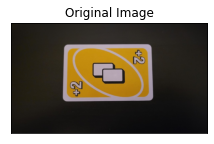

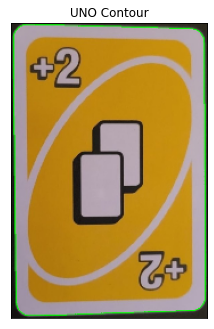

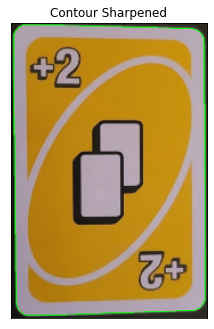

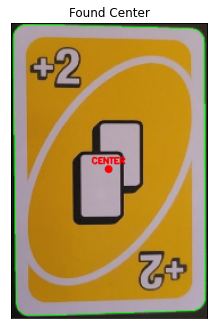

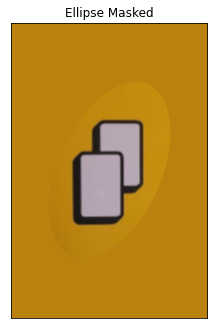

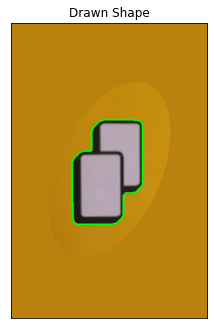

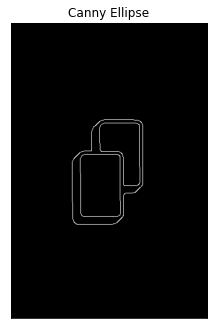

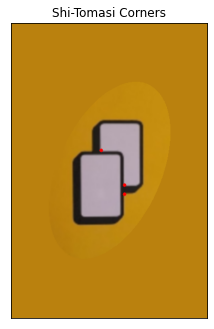

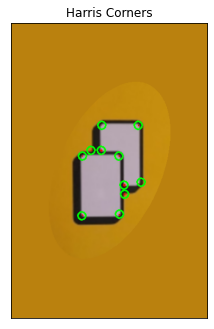

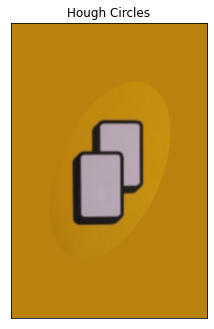

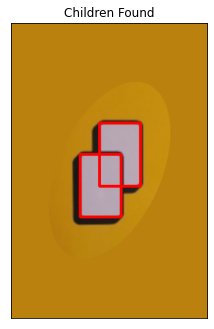

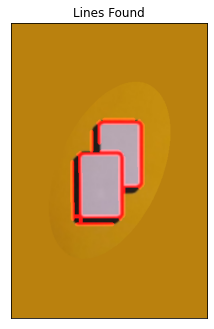

In [53]:
## --------------------------------------------------------------------------------------------DEFINITIONS-------------------------------------------------------------------------------------------
def map_value(value, in_low, in_high, out_low, out_high):                                              #create Arduino map() function in python for usage throughout the code
    return out_low + (out_high - out_low) * ((value - in_low) / (in_high - in_low))                    #scale input lowest,input highest range to output lowest,output highest range then return

def calculateDistance(x1,y1,x2,y2):
    dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist

def to_bw(image):
    output = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return output

def rotate_img(img, angle):
    result = ndimage.rotate(img, angle) 
    return result 

def find_contours(img_cnt, method, sigma = 0.33):
    img_cnt_bw = to_bw(img_cnt)                                                             #convert rescaled center image to black and white channels for post-processing
    blurred = cv2.GaussianBlur(img_cnt_bw, (3, 3), 0)
    th_cnt_value, th_cnt_img = cv2.threshold(blurred,100,200,cv2.THRESH_OTSU)                    #accurate countours, smoother edges compared to regular binary
    kernel_close = np.ones((3, 3), np.uint8)                                                               #higher kernel = less accurate contours
    morph_cnt_img = cv2.morphologyEx(th_cnt_img, cv2.MORPH_CLOSE, kernel_close)                       #erosion + dilute method (internal spaces removal)
    
    v = np.median(morph_cnt_img)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(morph_cnt_img, lower, upper) 
    
    if method == "EXTERNAL":
        contours_img_cnt, hierarchy_img_cnt = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
    elif method == "TREE":
        contours_img_cnt, hierarchy_img_cnt = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
    return contours_img_cnt, hierarchy_img_cnt, edged

def contour_removal_properties(image, min_corners, max_corners, min_ratio, max_ratio, min_height, max_height):
    contours_found, __ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 
    for c, cnt in enumerate(contours_found):                                                           # loop through all the found contours
        perimeter, area, corners = contour_properties(cnt)
        height, width = shape_height_width(cnt)
        if not min_corners < corners < max_corners or min_ratio < area/perimeter < max_ratio or min_height < height < max_height:
            contours_found.pop(c) 
    return contours_found

def contour_removal_distance_centerpoints(contour_space, contour_space_center_x, contour_space_center_y, dist_min):
    for i, cnt in enumerate(contour_space):
        M = cv2.moments(cnt)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        if ((((cx - contour_space_center_x)**2) + ((contour_space_center_y)**2))**0.5) > dist_min:
            contours_space.pop(i)
    return contour_space

def draw_selected_contour(original, contour_space, contour, R,G,B, thickness):
    drawn_contours_img = cv2.drawContours(original, contour_space[contour], -1, (R,G,B), thickness, cv2.LINE_AA)
    return drawn_contours_img

def yougest_children_img(image_children):
    contours_space_cnt, hierarchy_space_cnt, ____= find_contours(image_children, "TREE")
    hierarchy_space_cnt = hierarchy_space_cnt[0]
    hierarchy_children_img = image_children.copy()
    children_found = 0
    for component in zip(contours_space_cnt, hierarchy_space_cnt):
        currentContour = component[0]
        currentHierarchy = component[1]
        x,y,w,h = cv2.boundingRect(currentContour)
        if currentHierarchy[2] < 0:                                                                            # these are the innermost child components            
            cv2.rectangle(hierarchy_children_img ,(x,y),(x+w,y+h),(0,0,255),3)
            children_found += 1
    return children_found, hierarchy_children_img

def find_center(image):
    contour_bw = to_bw(image)                                                              #convert rescaled center image to black and white channels for post-processing
    thr_value2, th_shape_img = cv2.threshold(contour_bw,127,255,cv2.THRESH_OTSU)                    #accurate countours, smoother edges compared to regular binary
    kernel_close = np.ones((3, 3), np.uint8)                                                               #higher kernel = less accurate contours
    morph_shape_img = cv2.morphologyEx(th_shape_img , cv2.MORPH_CLOSE, kernel_close)                       #erosion + dilute method (internal spaces removal)
    canny_shape_img = cv2.Canny(morph_shape_img, 150, 500)  
    contours_shape, hierarchy_shape = cv2.findContours(canny_shape_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) 

    center_identified_img = image.copy()
    M = cv2.moments(contours_shape[1])
    if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        cv2.circle(center_identified_img, (cx, cy), 7, (0, 0, 255), -1)
        cv2.putText(center_identified_img, "CENTER", (cx - 30, cy - 10),
                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        return center_identified_img, cx, cy
    else:
        return center_identified_img, 0, 0

def contour_extraction(image, contours_space, cnt):
    mask = np.zeros_like(image) # Create mask where white is what we want, black otherwise
    cv2.drawContours(mask, contours_space, cnt, 255, -1) # Draw filled contour in mask
    masked = np.zeros_like(image) # Extract out the object and place into output image
    masked[mask == 255] = image[mask == 255]
    return masked

def contour_bound_crop(img, cnts, cnt):
    [x,y,w,h] = cv2.boundingRect(cnts[cnt])
    box = cv2.rectangle(img.copy(), (x, y), (x + w, y + h), (0,0,255), 2)
    cropped = img[y-10:y+h+10, x-10:x+w+10]
    return cropped, box

def sharpen_image(image, sharpness, threshold):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, (5,5) , 1.0)
    sharpened = float(sharpness + 1) * image - float(sharpness) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

def contour_properties(contour_selected, req):
    perimeter = cv2.arcLength(contour_selected, True)                                                                    # perimeter of contour c (curved length)     
    area = cv2.contourArea(contour_selected)                                                                     
    corners = len(cv2.approxPolyDP(contour_selected, 0.04*perimeter, True))
    if req == "A":
        return area
    elif req == "P":
        return perimeter
    elif req == "C":
        return corners

def shape_ratio(perimeter, area):
    ratio = area/perimeter   
    return ratio

def fit_ellipse(contour_selected):
    try:
        ellipse_found = cv2.fitEllipse(contour_selected)                                                                      # fit an ellipse on the contour
        (center, axes, orientation) = ellipse_found                                                            # extract the main parameter
        majoraxis_length = max(axes)                              
        minoraxis_length = min(axes)
        return minoraxis_length, majoraxis_length
    except (cv2.error, ZeroDivisionError) as e:
        return 0, 0

def shape_height_width(contour_selected, val):
    try:
        minor, major = fit_ellipse(contour_selected)
        if val == "H":
            return major/minor
        if val == "W":
            return minor/major
    except (cv2.error, ZeroDivisionError) as e:
        return 0

def contour_masking(morphology, cnts, selected):
    mask = np.zeros_like(morphology)                                                               # Create mask where white is what we want, black otherwise
    cv2.drawContours(mask, cnts, selected, 255, -1)                                       # Draw filled contour in mask
    masked = np.zeros_like(morphology)                                                              #Extract out the object and place into output image
    masked[mask == 255] = morphology[mask == 255]
    return masked

def harris_method_corners(image):
    harris_method_BGR_img= image.copy()
    harris_method_bw_img = np.float32(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
    dst = cv2.cornerHarris(harris_method_bw_img,5,3,0.04)
    ret, dst = cv2.threshold(dst,0.1*dst.max(),255,0)
    dst = np.uint8(dst)
    ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
    harris_corners = cv2.cornerSubPix(harris_method_bw_img,np.float32(centroids),(5,5),(-1,-1),criteria)
    harris_method_BGR_img[dst>0.1*dst.max()]=[0,0,255]   
    
    for c in range(1, len(harris_corners)):
        cv2.circle(harris_method_BGR_img, (int(harris_corners[c,0]), int(harris_corners[c,1])), 7, (0,255,0), 2)
    
    return c, harris_method_BGR_img

def shi_tomasi_method_corners(image):
    shi_tomasi_BGR_img= image.copy()
    shi_tomasi_method_bw_img = cv2.cvtColor(shi_tomasi_BGR_img, cv2.COLOR_BGR2GRAY)
    shi_tomasi_corners = cv2.goodFeaturesToTrack(shi_tomasi_method_bw_img, 0, 0.25, 0.05)
    shi_tomasi_corners = np.int0(shi_tomasi_corners)
                                                                                                  
    for i in shi_tomasi_corners:                                                                                    # draw red color circles on all corners
        x, y = i.ravel()
        cv2.circle(shi_tomasi_BGR_img, (x, y), 3, (0, 0, 255), -1)
    return len(shi_tomasi_corners), shi_tomasi_BGR_img

def houghcircles(image, min_radius, max_radius, circle_dist):
    ___, center_x, center_y = find_center(image)
    circles_count = 0   
    houghcircles_BGR_img= image.copy()
    houghcircles_bw_img = cv2.cvtColor(houghcircles_BGR_img, cv2.COLOR_BGR2GRAY)
    rows = houghcircles_bw_img.shape[0]
    circles = cv2.HoughCircles(houghcircles_bw_img, cv2.HOUGH_GRADIENT, 1, rows / circle_dist,
                               param1=100, param2=30, minRadius=min_radius, maxRadius=max_radius)
    
    dist_center_circle = 0
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            center = (i[0], i[1]) 
            dist_center_circle += int(calculateDistance(center[0],center[1],center_x,center_y))
            cv2.circle(houghcircles_BGR_img, center, 1, (0, 100, 100), 3)                           # circle center           
            radius = i[2]                                                                              # circle outline
            cv2.circle(houghcircles_BGR_img, center, radius, (255, 0, 255), 3)
        circles_count = int(circles.size/3)
    return circles_count, houghcircles_BGR_img, dist_center_circle

def houghlines(image, canny_edges):
    lines_img = image.copy()
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 10  # angular resolution in radians of the Hough grid
    threshold = 17 # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 15  # minimum number of pixels making up a line
    max_line_gap = 18 # maximum gap in pixels between connectable line segments
    line_image = np.copy(image) * 0  # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(canny_edges, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)
    line_counter = 0
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                line_counter += 1
                cv2.line(line_image,(x1,y1),(x2,y2),(0,0,255),5)

        lines_edges = cv2.addWeighted(lines_img, 1, line_image, 1, 0)

        parallel = []
        for i in range(len(lines)):
            for j in range(len(lines)):
                if (i == j):continue
                if (abs(lines[i][0][1] - lines[j][0][1]) == 0):         
                    parallel.append((i,j))
        return line_counter, lines_edges, len(parallel)
    
def center_shape(img_frame, mina, maxa, b, g, r):
    mask = np.zeros_like(img_frame)
    rows, cols,_ = mask.shape
    center_x = int(rows/2)
    center_y = int(cols/2)
    center = (center_y,center_x)

    mask = cv2.ellipse(mask, center, axes=(mina, maxa), angle=24, startAngle=0, endAngle = 360, color=(255,255,255), thickness = -1)
    ellipse_masked_img = np.bitwise_and(img_frame, mask)
    ellipse_masked_img[np.all(ellipse_masked_img == (0, 0, 0), axis=-1)] = (b, g, r)

    return ellipse_masked_img
#----------------------------------------------------------------------------------------IMAGE PRE-PROCESSING---------------------------------------------------------------------------------------
input_img = cv2.imread('./highres_personal_uno_images/yT.jpg')                                                         #load the image from the specified path
rotated_img = rotate_img(input_img, -90)                                                          #rotate image by 90 degrees, increase user ease of use
bw_img = to_bw(rotated_img)                                                 #convert to a black and white image


#-------------------------------------------------------------------------------------------POST-PROCESSING-----------------------------------------------------------------------------------------
thr_value, th_img = cv2.threshold(bw_img,150, 400, cv2.THRESH_BINARY_INV)                              #accurate countours, smoother edges compared to regular binary
kernel = np.ones((3, 3), np.uint8)                                                                     #higher kernel = less accurate contours
#close_img = cv2.morphologyEx(img_th, cv2.MORPH_CLOSE, kernel)                                         #erosion + dilute method (internal spaces removal)
open_img = cv2.morphologyEx(th_img, cv2.MORPH_OPEN, kernel)                                            #dilute + erosion method (noise removal)


#-----------------------------------------------------------------------------------EDGE DETENCTION & CONTOUR MAPPING---------------------------------------------------------------------------------
canny_img = cv2.Canny(open_img, 50, 100)                                                               #edge detection using the OpenCV Canny method
#cv2.imshow('test',canny_img)
contours, _ = cv2.findContours(open_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)  
selected_contour = 1                                                                                   #0 = frame; 1 = uno card perimeter; 
contours_img = draw_selected_contour(rotated_img, contours, selected_contour, 0,255,0, 2)              #draw selected contour on top of the rotated colour image
#print(len(contours))                                                                                  #debugging: show how many contours have been found
#print(hierarchy)                                                                                      #debugging: show hierarchy list for all contours



#---------------------------------------------------------------------------OPEN CV CONTOUR CROPPING USING CONTOURS FUNCTION--------------------------------------------------------------------------- 
x_cnt,y_cnt,w_cnt,h_cnt = cv2.boundingRect(contours[selected_contour])                                 #find origin, width and heigth of image based on selected_contour
contour_cropped_proc_img = (rotated_img.copy())[y_cnt-7:y_cnt+h_cnt+7, x_cnt-7:x_cnt+w_cnt+7]          #crop the image based on the coordinates found for processing
#print(x_cnt, y_cnt, w_cnt, h_cnt)                                                                     #print 4 values for debugging

#---------------------------------------------------------------------------RESOLUTION NORMALIZATION--------------------------------------------------------------------------- 
resolution_input_img = list(contour_cropped_proc_img.shape)
resolution_input_img = resolution_input_img[:-1]
#print(resolution_input_img, type(resolution_input_img))

if resolution_input_img[1] > resolution_input_img[0]:
    contour_cropped_proc_img = cv2.resize(contour_cropped_proc_img, (260, 173)) 
else:
    contour_cropped_proc_img = cv2.resize(contour_cropped_proc_img, (173, 260))

contour_cropped_analysis_img = contour_cropped_proc_img.copy()                                #crop the rotated original image copy with the uno card contour for pattern/colour processing
#---------------------------------------------------------------------------DISPLAY FRAME--------------------------------------------------------------------------- 
framed_img = cv2.copyMakeBorder(contour_cropped_proc_img,                                              #add a 30px wide black frame around the cropped image (helps with text placement) 
                                30,30,30,30,
                                cv2.BORDER_CONSTANT,
                                value=(0,0,0)) 

#-----------------------------------------------------------------------------------------COLOUR ANALYSIS------------------------------------------------------------------------------------------ 
#a patch of pixels is chosen to increase accuracy 
#as well as optimise the code by running through less pixels in the functions to follow
center_analysis_img, center_analysis_x, center_analysis_y = find_center(contour_cropped_analysis_img)
colour_patch_img = contour_cropped_analysis_img[center_analysis_y-55:center_analysis_y-45,center_analysis_x-225:center_analysis_x-215]                                        #select a constant patch from the uno card image to perform the pixel analysis
bgr_pixels = colour_patch_img.tolist()                                                                 #transform patch array to list containing bgr tuples
#print(bgr_pixels)
b = [x[0][0] for x in bgr_pixels]                                                                      #extract blue values from bgr list
g = [x[0][1] for x in bgr_pixels]                                                                      #extract green values from bgr list
r = [x[0][2] for x in bgr_pixels]                                                                      #extract red values from bgr list
frequent_b = (max(set(b), key = b.count))                                                              #find the most frequent blue value in the image patch selected
frequent_g = (max(set(g), key = g.count))                                                              #find the most frequent green value in the image patch selected
frequent_r = (max(set(r), key = r.count))                                                              #find the most frequent red value in the image patch selected

raw_menu = input("\n Choose the method for colour identification: \n Press 1 for the Patch Analysis method. \n Press 2 for the OpenCV Mask method. \n")                                             #Print string and wait for user input
if raw_menu.isdigit():                                                                     #INPUT CHECK: If the input is a digit continue with the choices:
    menu = int(raw_menu)                                                                   #Create new variable and store integer value of input
    if (menu == 1):                                                                        #If input is 1:
        #-----------------------------------------------------------------------------------------COLOUR IDENTIFICATION - METHOD 1------------------------------------------------------------------------------------------  
        rgb_dictionary = {"red": frequent_r, "green": frequent_g, "blue": frequent_b}                          #create dictionary containing the RGB colour space, and assign most frequent value from patch
        sorted_rgb_dictionary = dict((y, x) for y, x in sorted(rgb_dictionary.items(),                         #sort dictionary based on value, not key and since the output is a tuple, transform to dictionary
                                                               key=operator.itemgetter(1)))                    #choose value for sorting process, (1) = value, (0) = key
        highest_rgb_value = list(sorted_rgb_dictionary)[2]                                                     #extract highest value whether it is a blue, green or red pixel (key)
        middle_rgb_value = list(sorted_rgb_dictionary)[1]                                                      #extract middle value whether it is a blue, green or red pixel (key)
        lowest_rgb_value = list(sorted_rgb_dictionary)[0]                                                      #extract lowest value whether it is a blue, green or red pixel (key)

        #the following part of the code changes the R,G,B values of the pixels to an extreme
        #this helps identify the colour correctly with different levels of brightness in the image
        colour_rgb = [0,0,0]                                                                                   #create list to store the new RGB values for colour identification
        if sorted_rgb_dictionary.get(highest_rgb_value) >= 255/2:                                              #if the highest pixel value is higher than the mid-point, then:
            if highest_rgb_value == "red":                                                                     #if the highest_rgb_value is a "red" pixel, then:
                colour_rgb[0] = 255                                                                                #assign the first element in the colour_rgb = 255 
            elif highest_rgb_value == "green":                                                                 #if the highest_rgb_value is a "green" pixel, then:
                colour_rgb[1] = 255                                                                                #assign the second element in the colour_rgb = 255 
            elif highest_rgb_value == "blue":                                                                  #if the highest_rgb_value is a "blue" pixel, then:
                colour_rgb[2] = 255                                                                                #assign the third element in the colour_rgb = 255 
        if sorted_rgb_dictionary.get(highest_rgb_value) <= 255/2:                                            #if the highest pixel value is lower than the mid-point, then:
            if highest_rgb_value == "red":                                                                     #if the highest_rgb_value is a "red" pixel, then:
                colour_rgb[0] = 128                                                                                #assign the first element in the colour_rgb = 128 
            elif highest_rgb_value == "green":                                                                 #if the highest_rgb_value is a "green" pixel, then:
                colour_rgb[1] = 128                                                                                #assign the second element in the colour_rgb = 128 
            elif highest_rgb_value == "blue":                                                                  #if the highest_rgb_value is a "blue" pixel, then:
                colour_rgb[2] = 0                                                                                  #assign the third element in the colour_rgb = 128 
        if sorted_rgb_dictionary.get(middle_rgb_value) > 130:                                               #if the middle pixel value is higher than 150, then:
            if middle_rgb_value == "red":                                                                      #if the middle_rgb_value is a "red" pixel, then:
                colour_rgb[0] = 255                                                                                #assign the first element in the colour_rgb = 255 
            elif middle_rgb_value == "green":                                                                  #if the middle_rgb_value is a "green" pixel, then:
                colour_rgb[1] = 255                                                                                #assign the second element in the colour_rgb = 255 
            elif middle_rgb_value == "blue":                                                                   #if the middle_rgb_value is a "blue" pixel, then:
                colour_rgb[2] = 255                                                                                #assign the third element in the colour_rgb = 255 
        if sorted_rgb_dictionary.get(middle_rgb_value) <= 130:                                                  #if the middle pixel value is higher than 150, then:
            if middle_rgb_value == "red":                                                                      #if the middle_rgb_value is a "red" pixel, then:
                colour_rgb[0] = 0                                                                               #assign the first element in the colour_rgb = 255 
            elif middle_rgb_value == "green":                                                                  #if the middle_rgb_value is a "green" pixel, then:
                colour_rgb[1] = 0                                                                                  #assign the second element in the colour_rgb = 255 
            elif middle_rgb_value == "blue":                                                                   #if the middle_rgb_value is a "blue" pixel, then:
                colour_rgb[2] = 0                                                                                  #assign the third element in the colour_rgb = 255 
        if sorted_rgb_dictionary.get(lowest_rgb_value) < 255/2:                                                #if the lowest pixel value is lower than the mid-point, then:
            if lowest_rgb_value == "red":                                                                      #if the lowest_rgb_value is a "red" pixel, then:
                colour_rgb[0] = 0                                                                                  #assign the first element in the colour_rgb = 0 
            elif lowest_rgb_value == "green":                                                                  #if the lowest_rgb_value is a "green" pixel, then:
                colour_rgb[1] = 0                                                                                  #assign the second element in the colour_rgb = 0 
            elif lowest_rgb_value == "blue":                                                                   #if the lowest_rgb_value is a "blue" pixel, then:
                colour_rgb[2] = 0                                                                                  #assign the third element in the colour_rgb = 0 

        named_colour = rgb_to_name(colour_rgb)                                                                 #use webcolours library database to convert RGB to HEX and then to colour name in English 

        """
        #Debugging
        #test = name_to_rgb('cyan') 
        #print(test)
        #print(type(highest_rgb_value))
        print(lowest_rgb_value, middle_rgb_value, highest_rgb_value)
        print(sorted_rgb_dictionary)
        print(colour_rgb)
        #print(colour, named_colour)
        """
    elif (menu == 2):                                                                        #If input is s:
        #-----------------------------------------------------------------------------------------COLOUR IDENTIFICATION - METHOD 2------------------------------------------------------------------------------------------  
    
        hsv_colours = cv2.cvtColor(contour_cropped_proc_img, cv2.COLOR_BGR2HSV)
        named_colour = ''
        colour_rgb = [0,0,0]
        # define range wanted color in HSV
        red_lower1, red_upper1 = np.array([0,50,20], np.uint8), np.array([10,255,255], np.uint8) 
        red_lower2, red_upper2 = np.array([170,50,20], np.uint8), np.array([180, 255, 255], np.uint8)
        red_mask1, red_mask2 = cv2.inRange(hsv_colours, red_lower1, red_upper1), cv2.inRange(hsv_colours, red_lower2, red_upper2)
        red_mask = cv2.bitwise_or(red_mask1, red_mask2)
        
        green_lower, green_upper = np.array([45, 100, 50], np.uint8), np.array([75, 255, 255], np.uint8)                                                     #set the lower HSV range for the GREEN colour
        green_mask = cv2.inRange(hsv_colours, green_lower, green_upper)

        blue_lower, blue_upper = np.array([87, 150, 80], np.uint8), np.array([117, 255, 255], np.uint8)                                                     #set the lower HSV range for the BLUE colour
        blue_mask = cv2.inRange(hsv_colours, blue_lower, blue_upper)
        
        yellow_lower, yellow_upper = np.array([15,100,100], np.uint8), np.array([40,255,255], np.uint8)
        yellow_mask = cv2.inRange(hsv_colours, yellow_lower, yellow_upper)
        
        black_lower, black_upper = np.array([0, 0, 0], np.uint8), np.array([20, 20, 40], np.uint8)                                                        #set the lower HSV range for the BLACK colour
        black_mask = cv2.inRange(hsv_colours, black_lower, black_upper)
        
        masks = {"red" : red_mask  , "green" : green_mask, "blue" : blue_mask, "yellow": yellow_mask, "black" : black_mask}
        for n, item_masks in enumerate(masks.values()):
            pixels_counter = cv2.countNonZero(item_masks)  
            if np.sum(item_masks) > 0 and pixels_counter > 8000: named_colour = str(list(masks.keys())[n]); break 
            else: named_colour = str(list(masks.keys())[n])
            
    elif (menu > 2):                                                                              #INPUT CHECK: If input is higher than 12, then there's no weapon available
        print("\n There is no such method. Please input 1 or 2 for the desired method! \n")
else:                                                                                          #INPUT CHECK: If input is a character/string and not a digit, reset weapon choice
    print("\n You have typed a character, please insert a number for the desired method! \n")

#-------------------------------------------------------------------------------------CONTOUR CROPPED SCALING-----------------------------------------------------------------------------------------
contour_cropped = contour_cropped_analysis_img.copy()   
scale_percent = 200 # percent of original size
dim =  (int(contour_cropped.shape[1] * scale_percent / 100), int(contour_cropped.shape[0] * scale_percent / 100))
contour_cropped_resized = cv2.resize(contour_cropped, dim, interpolation = cv2.INTER_AREA)


#------------------------------------------------------------------------------------CONTOUR CROPPED SHARPENING/BLURRING----------------------------------------------------------------------------------------
contour_cropped_sharpened = sharpen_image(contour_cropped_resized, 0.22, 0)
kernel_size = 5
contour_cropped_blurred = cv2.GaussianBlur(contour_cropped_resized,(kernel_size, kernel_size),0)

#--------------------------------------------------------------------------------------CONTOUR CENTER-----------------------------------------------------------------------------------------------------
center_img, center_x, center_y = find_center(contour_cropped_sharpened)

#------------------------------------------------------------------------------------------------------------------------------------------------------
ellipse_cropped = contour_cropped_blurred.copy()

if resolution_input_img[1] > resolution_input_img[0]:
    ellipse_cropped = center_shape(ellipse_cropped, 165, 90, frequent_b, frequent_g, frequent_r)
else:
    ellipse_cropped = center_shape(ellipse_cropped, 90, 165, frequent_b, frequent_g, frequent_r)

#--------------------------------------------------------------------------------CENTER CROPPED POST-PROCESSING---------------------------------------------------------------------------------------
contours_center, hierarchy_center, canny_center_img = find_contours(ellipse_cropped, "EXTERNAL")

contours_final = list()
hierarchy_center = hierarchy_center[0]
cut = 0
for component in zip(contours_center, hierarchy_center):
    currentContour = component[0]
    currentHierarchy = component[1]
    if currentHierarchy[2] < 0:
        contours_final.append(currentContour)
        cut += 1

#-------------------------------------------------------------------------------------FEATURE SPACE RECOGNITION----------------------------------------------------------------------------------------
#defining all features
height_found, width_found, area_found, perimeter_found, poly_corners_found = 0,0,0,0,0
for i in range(len(contours_final)):
    drawn_contour_img = draw_selected_contour(ellipse_cropped.copy(), contours_final, i, 0,255,0, 2)
    area_found += contour_properties(contours_final[i], "A")
    perimeter_found += contour_properties(contours_final[i], "P")
    poly_corners_found += contour_properties(contours_final[i], "C")
    height_found += shape_height_width(contours_final[i], "H") 
    width_found += shape_height_width(contours_final[i], "W") 

ratio_found = shape_ratio(perimeter_found, area_found)    
harris_corners, harris_corners_img = harris_method_corners(ellipse_cropped)
shi_tomasi_corners, shi_tomasi_img = shi_tomasi_method_corners(ellipse_cropped)
lines_found, lines_found_image, parallel_instances_found = houghlines(ellipse_cropped, canny_center_img)
circles_found, houghcircles_img, distance_center_circles = houghcircles(ellipse_cropped, 20, 30, 8)
children_found_counter, children_found_img = yougest_children_img(ellipse_cropped)

features = [int(-(-ratio_found // 1)), float("{:.1f}".format(height_found)), float("{:.1f}".format(width_found)), children_found_counter, lines_found, 
                             parallel_instances_found, circles_found, distance_center_circles, harris_corners, shi_tomasi_corners, poly_corners_found]
#print([int(-(-ratio_found // 1)), float("{:.1f}".format(height_found)), float("{:.1f}".format(width_found))])
features_array = (np.array(features)).reshape(1, -1)

#Debugging
print("Card colour:", named_colour)
print(features_array)
print('\nChildren Found:', children_found_counter,
      '\nArea Found:', area_found,
      '\nPerimeter Found:', perimeter_found,
      '\nRatio Found:', ratio_found,
      '\nCorners Harris Method:', harris_corners,
      '\nCorners Poly-Constant:', poly_corners_found,
      '\nCorners Shi-Tomasi Method:', shi_tomasi_corners,
      '\nLines Found:', lines_found,
      '\nParallel Instances Found:', parallel_instances_found,
      '\nCircles Found:', circles_found,
      '\nDistance Center to Circle:', distance_center_circles,
      '\nCard Center X, Y:', center_x, center_y,
      '\nShape Height: ', height_found,
      '\nShape Width: ', width_found)

#-------------------------------------------------------------------------------------------IMAGE DISPLAY---------------------------------------------------------------------------------------------- 
titles = ['Original Image','UNO Contour','Contour Sharpened','Found Center','Ellipse Masked','Drawn Shape',
         'Canny Ellipse','Shi-Tomasi Corners','Harris Corners','Hough Circles','Children Found','Lines Found']
images = [input_img, contour_cropped, contour_cropped_sharpened, center_img, ellipse_cropped, drawn_contour_img, 
         canny_center_img, shi_tomasi_img, harris_corners_img, houghcircles_img, children_found_img, lines_found_image]
for i in range(12):
    f = plt.figure(figsize=(50, 50))
    f.add_subplot(1, 12, i + 1)
    plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.xticks([]), plt.yticks([])